# Assignment 1: Machine Learning Basics - Data exploration, processing and visualization

In these two assignements, you will do some data exploration using real-world data, and build a model to solve an important clinical problem. The assignments require you to use machine learning models and methods. This is a lot of background material here, and this first assignment will simply scratch the surface. We would highly recommend going through the slides and materials provided throughout this course.  

## Overview

PhysioNet provides access to an open dataset of physiological signals, and each year they host a challenge. Challenges in previous years include detecting sleep apnea using ECG, predicting hypotensive episodes and classifying heart sounds. For a full list, see https://physionet.org/challenge/. Last year's challenge was to predict sepsis before it occurs based on demographic information (for example, the person's age), vital signs (for example, the person's temperature) and laboratory test results (for example, what is the level ). You will be attempting a simplified version of this project, where we have made some of the design decisions for you.

## What are your tasks

Please go through the notebook and complete any code where asked (marked `# TODO: `). Make sure you can answer the questions in sections __Machine Learning 1: data exploration__, __Machine Learning 2: basics__, and __Machine Learning 3: better balancing__. If you like, you can open a new text cell and write your answers there (please keep them short, 1-2 sentences is plenty!).

Finally, once you are sure everything works, run all the cells in the notebook (on Google Colaboratory, select `Runtime > Run all`, in Jupyter Lab, select `Run > Run All Cells`). Please save the resulting `.ipynb` file (on Google Colaboratory, select `File > Download .ipynb`) and share it with your instructors.

# Step 1: Familiarize yourself with the challenge

Read the Abstract, Objective and Challenge Data descriptions of the challenge at https://physionet.org/challenge/2019/. Pay particular attention to what data are available in the dataset and try to build a good understanding of what the objective of the challenge is.

In [1]:
pip install wget unzip

  Using cached wget-3.2.zip (10 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement unzip (from versions: none)
ERROR: No matching distribution found for unzip


# Step 2: Download required files

Download `training_setA.zip` from the PhysioNet 2019 challenge website and extract it (running the following cell).

In [2]:
!wget -nc https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip
!unzip -n training_setA.zip

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
"unzip" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


You may also need to install some python packages by running the following cell

In [3]:
!pip install scikit-learn numpy pandas cache-em-all imbalanced-learn

Scikit-learn, NumPy and Pandas are some of the most used python packages for data science. 

* [Scikit-learn](https://scikit-learn.org/stable/index.html) is a tool for data mining, data analysis and machine learning. 

* [NumPy](https://scikit-learn.org/stable/index.html) provides a fast implementation of arrays, matrices and common math operations. 

* [Pandas](https://pandas.pydata.org/) is an extremely useful library for working with data, especially when your data can be organized into tables (e.g., a csv or excel file). Getting familiar with these packages would be a good idea for both this assignment and if you want to do any kind of data analysis in Python. 

* [Imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) contains functions to help you work with imbalanced data.

* The final package, [cache-em-all](https://pypi.org/project/cache-em-all/), allows for saving the result of a function. In this assignment, some functions can take 5 or more minutes to run. So, cache-em-all allows you to save the result of the function so that it only takes 5 minutes the first time the function is called. Whenever the function is called again, it only takes a second or two to run. 

The following cell just imports the required modules and defines some helper function we wrote for you, and you do not need to do anything besides run the cell.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

from cache_em_all import Cachable

import os

DATA_DIR = "training" # Path to the data

# Names of all columns in the data that contain physiological data (vital signs + laboratory results)
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# Names of all columns in the data that contain demographic data
demographic_cols = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

# The combination of physiological and demographic data is what we will use as features in our model
feature_cols = physiological_cols + demographic_cols

# The name of the column that contains the value we are trying to predic
label_col = "SepsisLabel"

# Pre-calculated means and standard deviation of all physiological and demographic columns. We will use this to normalize
# data using their z-score. This isn't as important for simpler models such as random forests and decision trees,
# but can result in significant improvements when using neural networks
physiological_mean = np.array([
        83.8996, 97.0520,  36.8055,  126.2240, 86.2907,
        66.2070, 18.7280,  33.7373,  -3.1923,  22.5352,
        0.4597,  7.3889,   39.5049,  96.8883,  103.4265,
        22.4952, 87.5214,  7.7210,   106.1982, 1.5961,
        0.6943,  131.5327, 2.0262,   2.0509,   3.5130,
        4.0541,  1.3423,   5.2734,   32.1134,  10.5383,
        38.9974, 10.5585,  286.5404, 198.6777])
physiological_std = np.array([
        17.6494, 3.0163,  0.6895,   24.2988, 16.6459,
        14.0771, 4.7035,  11.0158,  3.7845,  3.1567,
        6.2684,  0.0710,  9.1087,   3.3971,  430.3638,
        19.0690, 81.7152, 2.3992,   4.9761,  2.0648,
        1.9926,  45.4816, 1.6008,   0.3793,  1.3092,
        0.5844,  2.5511,  20.4142,  6.4362,  2.2302,
        29.8928, 7.0606,  137.3886, 96.8997])
demographic_mean = np.array([60.8711, 0.0, 0.0, 0.0, -59.6769, 28.4551])
demographic_std = np.array([16.1887, 1.0, 1.0, 1.0, 160.8846, 29.5367])

@Cachable("flattened.csv")
def flatten(in_df, hours=4):
    res = []

    new_cols = []
    for i in range(hours):
        new_cols.append([c + "_" + str(i) for c in feature_cols])


    df = in_df.sort_values("hour")
    for patient, _df in df.groupby("patient"):
        n = int(len(_df) / hours)

        for i in range(n):
            window = _df.iloc[i*hours:(i+1)*hours]
            window_dict = {}

            for j in range(hours):
                for c in physiological_cols:
                    window_dict[c + "_" + str(j)] = window[c].iloc[j]

            for c in demographic_cols:
                window_dict[c] = window[c].iloc[0]

            window_dict[label_col] = window[label_col].mean()
            window_dict["patient"] = patient

            res.append(window_dict)

    res = pd.DataFrame(res)

    res = res[res[label_col] <= 1 / hours]
    res[label_col] = res[label_col].apply(lambda x: 1 if x else 0)

    return res

# Helper function: load_single_file

First, let's create a helper function that will load a single file from the dataset. If you look at the data in the training folder, you will see files like `"p000001.psv"`. This is a pipe separated file, similar to a comma-separated file, except each column is separated by a `"|"` instead of a comma. This helper function will take as input the path to one of these files (e.g. `"training/p000001.psv"`), use pandas to load the contents of the file, append some extra data and return the result.

First, you should look up the pandas `read_csv` function. It is a very simple way to read a csv file. For example,

In [5]:
df = pd.read_csv("C:/Users/Asus/Downloads/training_setA/training/p000001.psv", sep="|")
#df

Will read "training/p000001.psv" and load it into the variable df. Pandas uses what's called a DataFrame, which you can think of as a table, to represent data. If you want to see what a DataFrame looks like, try running the above code in your notebook and printing df.

This helper function also adds some extra information to the dataframe that we will be using later on. With a DataFrame, you can access a specific column using the square brackets (similar to a dict). So for example, if you read in one of the training files, you can run

In [6]:
df['HR']

0       NaN
1      97.0
2      89.0
3      90.0
4     103.0
5     110.0
6     108.0
7     106.0
8     104.0
9     102.0
10    104.0
11      NaN
12    102.0
13    108.0
14    106.0
15    109.0
16    103.0
17    104.0
18      NaN
19    109.0
20    113.0
21     98.0
22    100.0
23    102.0
24    108.0
25    107.0
26    104.0
27    102.0
28    106.0
29    112.0
30      NaN
31    107.0
32    111.0
33    104.0
34    102.0
35     99.0
36     97.0
37    110.0
38    108.0
39    117.0
40    107.0
41    117.0
42      NaN
43    114.5
44     96.0
45     84.0
46     86.0
47     99.5
48    100.0
49     76.0
50     81.0
51     85.0
52     86.0
53     84.0
Name: HR, dtype: float64

to view just the heart rate’s for this file. You can also use pandas to assign values to a column. So for example,

In [7]:
df["Hbg"] = df["Hgb"] * 10
df["weather"] = "sunny"

Line 1 will multiply all hemoglobin values by 10 (convert from g/dL to g/L). Line 2 will create a new column called "weather" and fill all rows with the value "sunny".

Now back to the helper function. Once you've read in the file, let's create a new column called "patient_id" that contains the name of the file this data came from. We will use the file name as a sort of patient ID to figure out later on which data belongs to which patient. Secondly, let's also create a column called "hour". If you remember from the PhysioNet data description, each row in the file represents an hour. This is fine for when our data is saved in a file, however as we're working with the data, we want to shuffle rows around a bit. Therefore, we would like the explicitly store the hour in a separate column. This can be achieved with the following code

In [8]:
df['hour'] = df.index

In [9]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Hbg', 'weather', 'hour'],
      dtype='object')

In Pandas, the index is a very important concept. However, it can also get somewhat complicated. Essentially, the index is used to identify and look up rows in the data table. When we read in the data using the read_csv function, pandas creates an index for us where the index value of each row was its row number in the csv file (i.e., the first row had an index value of 0, the second row had an index value of 1, etc.). So now, when we say assign the value of the index to the `“hour”` column, we are setting the hour to also be the row number. 

Therefore, for the *load_single_file* function should read the csv into a `DataFrame` and create two new columns: one for `“patient”` and one for `“hour”`. You can then return this `DataFrame`.

With this background, you should now be able to implement `load_single_file` below.

In [10]:
def get_patient_id_from_file_path(file_path):
    return file_path.split('/')[-1][:-4]

def load_single_file(file_path):
    df = pd.read_csv(file_path, sep="|")
    df['hour']=df.index
    df['patient'] = get_patient_id_from_file_path(file_path) 
   
    pass

In [11]:
load_single_file("C:/Users/Asus/Downloads/training_setA/training/p000001.psv")
get_patient_id_from_file_path("C:/Users/Asus/Downloads/training_setA/training/p000001.psv")

'p000001'

# Helper function: load_data

Now let's work on another helper function called `load_data`. The first one read in a single file and created a `DataFrame`, now this helper function will read in all data files and put them into a single data frame.

In pandas, adding rows to a `DataFrame` is possible. However, it is very slow. Instead, what we will do is read each file in our dataset and append it to a list and then use Pandas `concat` function to concatenate the list of `DataFrame` into a single `DataFrame`. You should use the `load_single_file` helper function you wrote earlier.

Then we will use the Pandas `concat` function to concatenate the list of `DataFrame`s into a single `DataFrame` (Note: only do this when you know that each `DataFrame` has the same columns. With this physionet data, we do know this to be the case).

To help you with this, we have provided a function called `get_data_files` that will give you a list of all the files in the dataset. Once you have this list, you can iterate over it and use your `load_single_file` function to load each file. Append the result of this to a list, and after the for loop, use the `concat`.

Once you have the concatenated `DataFrame`, use the following code to reset the indices in your dataframe. This calls a function we provided that simply reset the indices in your concatenated data frame. 

```
df = reset_frame(df)
```

At the end of the load_data function, return the concatenated and reset `DataFrame`.

Once you are sure this function is working correctly, you can un-comment the `@Cachable("data.csv")` line above the function. The next time you run the function, it's result will be saved. Subsequent calls to the function will load the saved data. If you realize there was a mistake in the function implementation and you have to fix it, you will also need to delete the `"cache"` folder. Otherwise, your fixed code will not be called, and instead, the old saved data will be returned.

In [12]:
def load_single_file(file_path):
    df = pd.read_csv(file_path, sep="|")
    df['hour']=df.index
    df['patient'] = get_patient_id_from_file_path(file_path) 
    return df

In [13]:
def get_data_files():
    # we will be leaving some files out, on purpose. Do not change this function!
    return [os.path.join(DATA_DIR, x) for x in sorted(os.listdir(DATA_DIR)) if int(x[1:-4]) % 5 > 0]

def reset_frame(data):
    data.reset_index(inplace=True, drop=True)
    return data

@Cachable("data1.csv")

def load_data():
    dfs=[]
    # TODO: Implement helper function: load_data
    for i in get_data_files():
    #print(i)
    
        dfs.append(load_single_file(i))
    big_frame = pd.concat(dfs, ignore_index=True)
    #return big_frame
    pass
    


In [14]:
DATA_DIR='C:/Users/Asus/Downloads/training_setA/training/'
get_data_files()
    

['C:/Users/Asus/Downloads/training_setA/training/p000001.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000002.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000003.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000004.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000006.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000007.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000008.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000009.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000011.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000012.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000013.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000014.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000016.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000017.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p000018.psv',
 'C:/Users/Asus/Downloads/training_setA/training/p00001

In [15]:
load_data()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,hour,patient
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,0,p000001
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,p000001
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,2,p000001
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,3,p000001
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,4,p000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631255,88.0,98.0,NaN,135.0,81.00,64.0,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,31,1,28,p020643
631256,96.0,98.0,38.72,174.0,97.00,72.0,16.0,NaN,2.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,32,1,29,p020643
631257,140.0,97.0,NaN,133.0,81.50,62.5,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,33,1,30,p020643
631258,120.0,96.0,NaN,154.0,118.00,105.0,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,34,1,31,p020643


In [16]:
df = load_data()
print(df.columns)
print(len(df))
print(df['SepsisLabel'].value_counts())
    


Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'hour', 'patient'],
      dtype='object')
631260
0    617461
1     13799
Name: SepsisLabel, dtype: int64


# Machine Learning 1: data exploration

We will now use the helper functions you implemented to load the data and try to understand the data a bit better.

## Basics

At the end of this section, you should be able to answer questions such as what are the different columns in the dataframe; how many rows you have in the entire dataset; how many rows where `"SepsisLabel"` is 0, how many where it is 1.

Insert cells and explore your dataset.

```
# This is some code you may find useful.
df = load_data()
print(df.columns)
print(len(df))
print(df['SepsisLabel'].value_counts())
```

Note: the first time you run **load_data()**, it may take a few minutes. Good time for a short break before you carry on!

### Questions
1) What is the size of the your dataset (i.e., how many rows)? 

2) What is the number of patients in your dataset?

3) How many columns do we have?

4) How many rows where `"SepsisLabel"` is 0, and how many where it is 1? 

5) What is the median age of patients included in the dataset, and how many males are in the dataset?

6) How many patients ended up developing sepsis in the ICU? 

7) Are the patients who developed sepsis older or younger than those who did not develop sepsis (use the median to make the comparison)?  

In [17]:
count_row = df.shape[0]
print('1- Size of dataset:', count_row, '\n')
print ('2- Number of patients: ',df['patient'].nunique(), '\n')
print('3-number of columns: ', df.shape[1], '\n')
print('4- Sepsis Label: ')
print(df['SepsisLabel'].value_counts(), '\n')
print('5- median age of patients: ',df['Age'].median(), '\n')
n=df.loc[df['Gender'] == 1]
print('Number of males:',n['patient'].nunique(), '\n')
icu = df[(df['ICULOS'] > 0) &(df['SepsisLabel'] ==1) ]
print('6 - number of patients developing sepsis in ICU: ', icu['patient'].nunique())


1- Size of dataset: 631260 

2- Number of patients:  16269 

3-number of columns:  43 

4- Sepsis Label: 
0    617461
1     13799
Name: SepsisLabel, dtype: int64 

5- median age of patients:  65.23 

Number of males: 9439 

6 - number of patients developing sepsis in ICU:  1442


In [18]:
print('Age of SEPSIS patients: ',df[df['SepsisLabel']==1]['Age'].mean())
print('Age of NOT sepsis patients: ',df[df['SepsisLabel']==0]['Age'].mean(), '\n')
a=df[df['SepsisLabel']==1]['Age'].mean()
b=df[df['SepsisLabel']==0]['Age'].mean()
if a>b:
    print('Older than NOT sepsis patient')
else:
    print ('Younger than NOT sepsis patient')

Age of SEPSIS patients:  62.7832241466771
Age of NOT sepsis patients:  62.98873156361016 

Younger than NOT sepsis patient


## Missing data

By now, you probably have noticed that the dataset has a certain amount of missing data. Moreover, the missing rate is different for the different variables. This is normal, in particular within healthcare. Some measurements are not carried out at every hour, or some information may simply not be recorded for a particular patient.

This is extremely important!!! If you have a variable with a high missing rate, you may want to exclude them from the prediction model (as it won't be that informative); or, if you want to include the variable in your model, you need to design a strategy to cope with it. 

Try to use the skills you have developed so far in order to answer the following couple of questions.

### Questions

8) How many missing values you found for heart rate (HR) and white blood cell count (WBC)?

9) Based on your analyses, which feature (or features) will you be excluding when building your model (if any)? Why?



In [19]:
## 8 question
print(df["HR"].isna().sum())
print(df["WBC"].isna().sum())

48774
583874


### 9 question
if there is a lot of missing values, it is better to drop them)

## Data Visualization

In this section, you will dig a bit deeper and visualize the data! 
Feel free to ignore the missing measurements for this analysis!

Use your developed acquired skills to visualize the distribution of the different features! To make it easier, here a simple line of code to display the distribution of heart rate values.

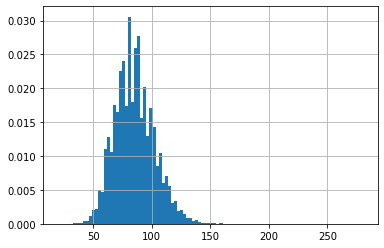

In [20]:
#df['HR'].hist(bins=100, grid=False, density=True, alpha=0.65, legend=True, figsize=(12,8))
hist = df['HR'].hist(bins=100,density=True)

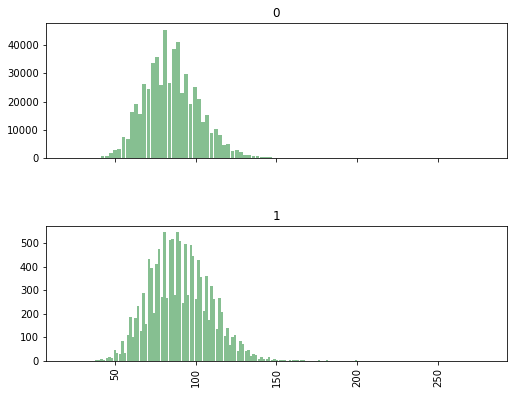

In [21]:
ax = df.hist(column='HR', by='SepsisLabel', bins=100, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)


Here, we used `"density=True"` in order to *normalize* the histogram (i.e., divided each bin by the total number of HR measurements)! We can see that most values of HR are within the [60, 120] beats per minute range.

Go ahead, and look at the distribution for all other features.

A more useful display would be to show the distribution of the features for the two classes (side-by-side, or overlayed in the same axis)! I.e., you can show on histogram to represent the distribtuion of `HR` measurements where `SepsisLabel=0`, and another histogram that represents the distribution of `HR` measurements where `SepsisLabel=1`. Can you see any difference between the two groups?


### Answer
yes, the number of non-sepsis patients(0) is more than sepsis patients(1). But in general they both have bell curve, both have heart rate between 50-150. And there is max number of people at heart rate 80-100. 

### Questions

10) Attempt to replicate to show the two histograms for `HR` and other features. Can you see a variable for which the distributions between the two groups/classes are substantially different (no or very little overlap)?

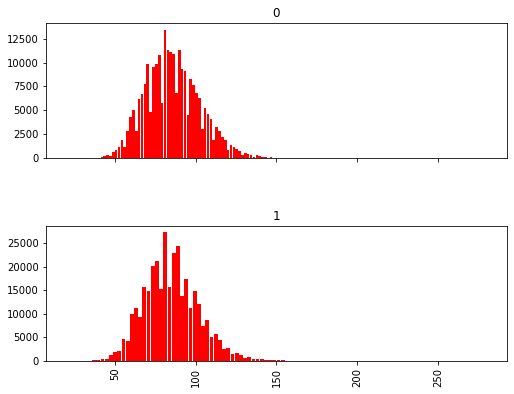

In [22]:
ax = df.hist(column='HR', by='Gender', bins=100, grid=False, figsize=(8,10),layout=(3,1), sharex=True, color='r', rwidth=0.9)

# Machine Learning 2: basics

In this section, we implement the function `train_simple`.


Now that you looked and know more about your data, lets try some machine learning. Because we are working with data that has labels (i.e., we know which rows are associated with sepsis), we will be using a type of learning called _supervised learning_. More specifically, given an input X, we are trying to predict an output y and we have examples of X, y pairs that we can use to train our model. In contrast, with unsupervised learning we would only have X and we would be trying to learn something about X.

Within supervised learning, there are two types of tasks: 1) classification and 2) regression. With classification, y is discrete (e.g. sepsis or not sepsis, picture is of cat, dog or bunny). With regression, y is continuous (e.g. white blood cell count, price of a house).

Remember the concept of generalization? We want the model we train to be able to predict accurately on data it has not seen before. One way we can do this is by splitting our data into two sets. One set, which we call the train set, will be used to train the model. The other, called the test set, will only be used to evaluate the model.

`Scikit-learn` provides a function that splits data into train and test. The test size is the proportion of data that should be used for the test set. In this case, 80% of the data is used for training, and 20% is used for testing. Here is the function you need to call in order to make this split.

In [23]:
train_df , test_df = train_test_split(df , test_size=0.2)

Everytime you run the cell above, you will see that `train_df` and `test_df` will be different! This will lead to small (but significant) differences in the results you may compute; i.e., it may lead to inconsistent results. Inconsistent results make it hard to replicate our work, therefore we would like a way to make our code produce the same result every time it is run. One way to do this is to set whats called a random seed. We can do this by adding the following lines right after our import statements. 

In [24]:
seed = 9001
np.random.seed(seed)

We also need to pass this seed to our the train test split function.

In [41]:
train_df , test_df = train_test_split(df ,test_size=0.2, random_state=seed)

In this case, I set a random seed of `9001`, but you can set it to whatever you like. But for a given seed, the program should produce the same result. So now  results you will be getting should be consistent.

## Clean and normalize your data

Before we can start training the model, we need to deal with one particular issue:

> **missing_data**

There are many approaches for dealing with missing data. One method, is to simply replace the missing values of a specific feature by the mean value (or mode for categorical data) of your training data for that feature (this is also called *mean imputation*).

Here, your life will be made easy! Use the `clean_and_normalize_data` function, to clean the two dataframes. This function first normalizes your dataset by subtracting the mean and dividing by the standard deviation.

In [26]:
def clean_and_normalize_data(df):
    data = df.copy()
    # Normalizes physiological and demographic data using the mean and standard deviation.
    data[physiological_cols] = (data[physiological_cols] - physiological_mean) / physiological_std
    data[demographic_cols] = (data[demographic_cols] - demographic_mean) / demographic_std

    # Maps invalid numbers (NaN, inf, -inf) to numbers (0, really large number, really small number)
    data[feature_cols] = np.nan_to_num(data[feature_cols])

    return data

Simply call the function for both data frames!

In [42]:
train_df = clean_and_normalize_data(train_df)
test_df = clean_and_normalize_data(test_df)

Now, the `train_df` and `test_df` contain cleaned and normalized data that should be used for training and testing, respectively. However, they both contain both X and y values. So lets further split these into train_X, train_y, test_X, test_y. Complete the function `get_data_and_labels`.

## Train your first model

Once you have X and y for both train and test sets, you will now create a classifier. Here, you will be creating a decision tree classifier as an example.

In [57]:
clf = DecisionTreeClassifier(class_weight="balanced")

There are many different types of classifiers available in **Scikit-learn**. We have already imported some of them and you can experiment with which ones work well. After creating the classifier, we need to fit/train it using our data. Lets call the fit function with our training data.

Once the model is fitted, we can evaluate how well it worked. To do this we can use the following code. What this does is:

* first, it uses our model to predict what it thinks the y value should be for a given X; for this, you can simply run `clf.predict(X)`. 

* then, using the models predicted y value and the actual y value, we compute evaluation accuracy, precision and recall using the provided helper function called evaluate.

You can see how well the model performs on the train set. Remember, this is the same data that was used to fit/train the model. We can expect to get fairly high performance on this data. Next, lets see how well the model does on unseen data (i.e., is the model generalizing). This can be done similar to the code below, but just by using the test X and y values. If the model performs significantly worse on the test set than the train set, we can say that the model is overfitting to the train set.

Using what you have learnt so far, try to complete `train_simple` method below! 

In [58]:
test_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,hour,patient
493045,-1.694086,0.977356,0.000000,-0.173836,-0.197688,-0.298854,-1.430424,0.0,0.000000,0.000000,...,0.000000,1.455268,1.0,0.0,0.0,0.370743,0.018448,0,28,p015919
91808,-1.977382,0.000000,0.000000,-0.379607,-0.077539,0.056333,1.120867,0.0,0.000000,0.000000,...,0.000000,-1.581418,1.0,0.0,0.0,-0.340885,0.255442,0,35,p002976
522119,-0.107630,-0.017240,0.000000,0.000000,-2.240233,0.000000,0.483045,0.0,0.000000,0.000000,...,0.000000,0.295817,0.0,0.0,0.0,0.094707,-0.861813,0,2,p016843
247161,1.195531,0.977356,0.000000,0.320016,0.282911,0.482557,0.057829,0.0,0.000000,0.000000,...,0.000000,-1.377572,0.0,0.0,0.0,0.335998,0.458579,0,41,p007977
567128,0.798917,-1.674900,0.000000,-1.161539,-1.098811,-1.222340,-0.792601,0.0,0.000000,0.000000,...,0.000000,0.187717,0.0,0.0,0.0,0.319278,-0.150833,0,23,p018309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230523,-0.107630,0.977356,0.000000,2.007342,0.000000,0.979818,-1.005209,0.0,0.000000,0.000000,...,0.000000,1.290338,1.0,1.0,0.0,0.370868,-0.794100,0,4,p007449
335990,-0.390925,0.000000,0.000000,-1.038076,-0.878336,0.000000,0.695652,0.0,0.000000,0.000000,...,0.000000,-0.619018,1.0,0.0,0.0,0.365709,-0.794100,0,4,p010823
363252,-0.560903,0.645824,0.000000,0.402324,0.463135,0.340482,0.270437,0.0,0.000000,0.000000,...,0.000000,0.760339,0.0,0.0,0.0,0.265264,0.052304,0,29,p011694
273709,0.175666,-0.017240,0.572154,-0.873459,-0.678287,-0.369892,-1.005209,0.0,0.579284,0.780815,...,1.437799,0.305701,1.0,0.0,1.0,0.220822,-0.557107,0,11,p008823


In [64]:
clean_and_normalize_data(df)
Y = train_df["SepsisLabel"]
X = train_df[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS']]


In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=seed)

In [66]:
# Build a decision tree model
model_dt = DecisionTreeClassifier(class_weight="balanced")
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced')

In [67]:
# Check the model performance with the training data
predictions_dt = model_dt.predict(X_train)
print("DecisionTreeClassifier", accuracy_score(Y_train, predictions_dt))

DecisionTreeClassifier 0.9999900991569433


In [68]:
predictions_dt = model_dt.predict(X_test)
print("DecisionTreeClassifier", accuracy_score(Y_test, predictions_dt))

DecisionTreeClassifier 0.9706936496307004


In [69]:
def evaluate(actual, predicted, prefix=""):
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)

    print("%s Precision: %.3f%%, Recall: %.3f%%, Accuracy: %.3f%%" % (prefix, precision * 100, recall * 100, accuracy * 100))


def get_data_and_labels(df, feature_cols, label_col):
    # TODO: Implement helper function: get_data_and_labels
    Y = train_df[label_col]
    X = train_df[feature_cols]
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=seed)
   
    # the function should return X and y
    return X,Y

# a function that trains a model (called clf)
def train_simple(data, feature_cols, label_col):
    # TODO: Implement helper function: train_simple
    get_data_and_labels(data, feature_cols, label_col)
    clf = DecisionTreeClassifier(class_weight="balanced")
    clf.fit(X_train, Y_train)
    #       does not need to return any argument
    #       just make sure that after you obtain your X and y you call clf.fit(X, y)!
    pass

Now, how does the model perform? Is the performance on the training set significantly higher than the test set? If so, this indicates overfitting. You can think of this as the model is memorizing the answers rather than learning the concepts. One way around this is to limit the complexity of the model. For example, we can create our model with the parameters shown below. This is how deep and wide the decision tree can be, which effectively limits it’s ability to memorize answers. The selection of these parameters is also a complex task and you should be careful about how you go about selecting these parameters because you can introduce another form of overfitting (let's leave that to the next assignment).

```
clf = DecisionTreeClassifier(class_weight=" balanced " ,max_depth=20, max_leaf_nodes=20)
```

In [70]:
train_simple(train_df, feature_cols=[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS']], label_col='SepsisLabel')

KeyError: "None of [Index([('HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS')], dtype='object')] are in the [columns]"

### Questions

11) What precision, recall and accurracy did you obtain on the training set?

12) What precision, recall and accurracy did you obtain on the test set?

13) Do you believe you are underfitting or overfitting the training data?

# Machine Learning 3: better balancing

In this section, we implement the function `train_balanced`.

You probably have noticed that the accuracy achieved is quite high, despite a lower precision and recall values. Why?   

Do you remember how many rows we had where the SepsisLabel was 1 (positive examples) and how many there were with 0 (negative examples)? When this proportion is heavily skewed to one side, we call this an **imbalance**. With a strong imbalance, classifiers may not learn as well because there are too few examples of a particular class (e.g. 0 or 1, cat or dog or bunny). The class_weight="balance" is one way to deal with a class imbalance. It tells the classifier to weigh classes relative to how many examples there are in the training data. For example, if there are twice as many negative examples than positive examples, the classifier will consider getting a positive examples wrong twice as bad as a negative examples.

Another way to deal with class imbalance is undersampling. This can be achieved with the code shown below. You can read about it in more detail here (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html). The ratio 0.5 tells the sampler to have a 1:1 ratio of positive and negative examples. A ratio of 0.1 would result in a 1:10
ratio.

In [ ]:
rus = RandomUnderSampler(0.5, random_state=seed)

Now, use what you've learned above to implement the `train_balanced` function.

In [ ]:
clfb = DecisionTreeClassifier(class_weight="balanced")

# a function that trains a model (called clfb)
def train_balanced(data, feature_cols, label_col):
    # TODO: Implement helper function: train_balanced
    #       does not need to return any argument
    #       just make sure that after you obtain your X and y you call clfb.fit(X, y)!
    pass

### Question

14) How does your model perform now? Better?

# Wrap-up

Well done on getting to the end of this assignment. You went through plenty of machine learning material, including data loading, data exploration, visualization and processing, and you trained a machine learning model for predicting sepsis in patients in hospitals using clinical information.

Our approach so far is a valid one. There are a couple of things that we can (and should) improve, though.

1) In the earlier sections, we talked about splitting data into train and test sets and how that helps with generalizability. We attempted to split data into independent train and test sets. However, it turns out our sets weren't so independent. We were deciding whether each row should go into the training or testing set. However, multiple rows belong to a single patient. If we have data from patient _P_ in the training set, isn’t it kind of like cheating to have data from patient _P_ in the test set as well? What we would really like is if the model worked on patients that it had never seen before.

2) We looked at a few metrics to evaluate our trained machine learning models. There are a few other metrics we can look at to make more informed decisions on what models are performing better.

3) Finally, we can see how other machine learning methods perform for this task. In addition, as we already alluded to, we can attempt to find better hyperparameters for training our models! 



If time allows, we will explore these three issues in your next assignment.